In [ ]:
!pip install findspark

In [ ]:
!pip install pyspark


In [ ]:
import findspark
findspark.init()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
file_path = '/content/drive/Shareddrives/603/Alcohol-Related_Disease.csv'

In [ ]:
!pip install gdown


**DATA CLEANING**

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("ReadCSVFromGoogleDrive").getOrCreate()
df = spark.read.csv(file_path, header=True, inferSchema=True)
df.show()


+---------+-------+------------+-------------+----------+-------------+--------------------+--------------------+--------------------+---------------+----------+--------------+--------------------------+-------------------+---------------+--------------------+-------+-----------+--------+----------+---------------+----------+----------------+--------+-------------+------+-------------+----------+---------------+---------------+
|YearStart|YearEnd|LocationAbbr| LocationDesc|DataSource|ConditionType|            Category|      Cause_of_Death|     Data_Value_Unit|Data_Value_Type|Data_Value|Data_Value_Alt|Data_Value_Footnote_Symbol|Data_Value_Footnote|         Effect|  ConsumptionPattern|    Sex|AgeCategory|AgeGroup|LocationID|ConditionTypeID|CategoryID|Cause_of_DeathID|EffectID|ConsumptionID| SexID|AgeCategoryID|AgeGroupID|DataValueTypeID|DataValueUnitId|
+---------+-------+------------+-------------+----------+-------------+--------------------+--------------------+--------------------+--

In [ ]:
num_rows = df.count()
num_columns = len(df.columns)
print(f"Shape of the DataFrame: ({num_rows}, {num_columns})")

Shape of the DataFrame: (62504, 30)


In [ ]:
df.describe().show()

+-------+--------------------+-------+------------+------------+----------+-------------+--------------------+-------------------+--------------------+---------------+------------------+------------------+--------------------------+--------------------+------------------+--------------------+-------+-----------+--------+------------------+---------------+----------+----------------+--------+-------------+------+-------------+----------+---------------+---------------+
|summary|           YearStart|YearEnd|LocationAbbr|LocationDesc|DataSource|ConditionType|            Category|     Cause_of_Death|     Data_Value_Unit|Data_Value_Type|        Data_Value|    Data_Value_Alt|Data_Value_Footnote_Symbol| Data_Value_Footnote|            Effect|  ConsumptionPattern|    Sex|AgeCategory|AgeGroup|        LocationID|ConditionTypeID|CategoryID|Cause_of_DeathID|EffectID|ConsumptionID| SexID|AgeCategoryID|AgeGroupID|DataValueTypeID|DataValueUnitId|
+-------+--------------------+-------+------------+---

In [ ]:
from pyspark.sql.functions import col, sum

missing_values_count = df.agg(*[
    sum(col(column).isNull().cast("int")).alias(f"missing_{column}_count")
    for column in df.columns
])

columns_with_missing_values = [
    column for column in missing_values_count.columns if missing_values_count.first()[column] > 0
]

filtered_missing_values_count = missing_values_count.select(*columns_with_missing_values)

filtered_missing_values_count.show()



+------------------------+----------------------------+----------------------------------------+---------------------------------+
|missing_Data_Value_count|missing_Data_Value_Alt_count|missing_Data_Value_Footnote_Symbol_count|missing_Data_Value_Footnote_count|
+------------------------+----------------------------+----------------------------------------+---------------------------------+
|                     312|                       49323|                                   52564|                            52564|
+------------------------+----------------------------+----------------------------------------+---------------------------------+



If we observe from the above most of the data is missing Data_Value_Footnote_Symbol, Data_Value_Footnote_count. We don't require those columns for our Analysis

After Analysing the datset we have found that Data_Value_Alt is the duplicate column of Data_Value.

So let us remove those 3 columns.


In [ ]:
# List of columns to drop
columns_to_drop = ["Data_Value_Alt", "Data_Value_Footnote_Symbol", "Data_Value_Footnote"]
df_filtered = df.drop(*columns_to_drop)

In [ ]:
num_rows = df_filtered.count()
num_columns = len(df_filtered.columns)
print(f"Shape of the DataFrame: ({num_rows}, {num_columns})")
df_filtered.show()

Shape of the DataFrame: (62504, 27)
+---------+-------+------------+-------------+----------+-------------+--------------------+--------------------+--------------------+---------------+----------+---------------+--------------------+-------+-----------+--------+----------+---------------+----------+----------------+--------+-------------+------+-------------+----------+---------------+---------------+
|YearStart|YearEnd|LocationAbbr| LocationDesc|DataSource|ConditionType|            Category|      Cause_of_Death|     Data_Value_Unit|Data_Value_Type|Data_Value|         Effect|  ConsumptionPattern|    Sex|AgeCategory|AgeGroup|LocationID|ConditionTypeID|CategoryID|Cause_of_DeathID|EffectID|ConsumptionID| SexID|AgeCategoryID|AgeGroupID|DataValueTypeID|DataValueUnitId|
+---------+-------+------------+-------------+----------+-------------+--------------------+--------------------+--------------------+---------------+----------+---------------+--------------------+-------+-----------+------

Previously we had 30 columns but now we have only 27 columns

In [ ]:
#Replace the missing values in Data_Value with 0
from pyspark.sql.functions import col, sum, avg, min, max, count, expr
from pyspark.sql.functions import when
spark = SparkSession.builder.appName("ReplaceMissingValues").getOrCreate()
df_filtered = df_filtered.withColumn('Data_Value', when(col('Data_Value').isNull(), 0).otherwise(col('Data_Value')))
df_filtered.show()

+---------+-------+------------+-------------+----------+-------------+--------------------+--------------------+--------------------+---------------+----------+---------------+--------------------+-------+-----------+--------+----------+---------------+----------+----------------+--------+-------------+------+-------------+----------+---------------+---------------+
|YearStart|YearEnd|LocationAbbr| LocationDesc|DataSource|ConditionType|            Category|      Cause_of_Death|     Data_Value_Unit|Data_Value_Type|Data_Value|         Effect|  ConsumptionPattern|    Sex|AgeCategory|AgeGroup|LocationID|ConditionTypeID|CategoryID|Cause_of_DeathID|EffectID|ConsumptionID| SexID|AgeCategoryID|AgeGroupID|DataValueTypeID|DataValueUnitId|
+---------+-------+------------+-------------+----------+-------------+--------------------+--------------------+--------------------+---------------+----------+---------------+--------------------+-------+-----------+--------+----------+---------------+------

In [ ]:

missing_values_count = df_filtered.agg(*[
    sum(col(column).isNull().cast("int")).alias(f"missing_{column}_count")
    for column in df_filtered.columns
])

columns_with_missing_values = [
    column for column in missing_values_count.columns if missing_values_count.first()[column] > 0.0
]

filtered_missing_values_count = missing_values_count.select(*columns_with_missing_values)

filtered_missing_values_count.show()


++
||
++
||
++



If we observe from the above now no data is missing or NULL, we have cleansed the data. Now we are good to start our Analysis

In [ ]:
# we have observed the negative values in the Data_Value column. Deaths cannot be negative so we are taking the absolute value
df_filtered = df_filtered.withColumn("Data_Value", expr("ABS(Data_Value)"))

**DATA** **EXTRACTION** **AND VISUALIZATION**

1. **Total Deaths in Each State**

In [ ]:
from pyspark.sql.functions import col, sum, avg, min, max, count
spark = SparkSession.builder.appName("DeathAnalysis").getOrCreate()
df_filtered1 = df_filtered.filter(col("LocationDesc") != "United States")
total_deaths_by_state = df_filtered1.groupBy("LocationDesc").agg(
    sum("Data_Value").alias("TotalDeaths"),
    avg("Data_Value").alias("AverageDeaths")
)
total_deaths_by_state_sorted = total_deaths_by_state.orderBy(col("TotalDeaths").desc())
total_deaths_by_state_sorted.show()

+--------------+-----------+------------------+
|  LocationDesc|TotalDeaths|     AverageDeaths|
+--------------+-----------+------------------+
|    California|   284187.0| 659.3665893271461|
|         Texas|   196395.0| 489.7630922693267|
|       Florida|   194145.0|487.80150753768845|
|      New York|   122456.0|339.21329639889194|
|  Pennsylvania|   104519.0| 302.9536231884058|
|          Ohio|   103944.0| 303.9298245614035|
|      Illinois|    94275.0| 278.0973451327434|
|      Michigan|    82112.0| 248.0725075528701|
|North Carolina|    80292.0|          250.9125|
|       Georgia|    72111.0|228.92380952380952|
|       Arizona|    65929.0|223.48813559322033|
|     Tennessee|    60139.0|208.09342560553634|
|    Washington|    57104.0|189.71428571428572|
|      Virginia|    55574.0|183.41254125412541|
|    New Jersey|    54040.0|195.79710144927537|
|       Indiana|    53086.0| 185.6153846153846|
|      Missouri|    51752.0| 179.0726643598616|
| Massachusetts|    49195.0|176.32616487

In [ ]:
top_2_states = total_deaths_by_state_sorted.limit(2)
print("Top 2 states with the most deaths:")
top_2_states.show()
total_deaths_by_state_sorted_asc = total_deaths_by_state.orderBy(col("TotalDeaths"))
bottom_2_states = total_deaths_by_state_sorted_asc.limit(2).orderBy(col("TotalDeaths"))
print("States with the least deaths:")
bottom_2_states.show()

Top 2 states with the most deaths:
+------------+-----------+-----------------+
|LocationDesc|TotalDeaths|    AverageDeaths|
+------------+-----------+-----------------+
|  California|   284187.0|659.3665893271461|
|       Texas|   196395.0|489.7630922693267|
+------------+-----------+-----------------+

States with the least deaths:
+------------+-----------+-----------------+
|LocationDesc|TotalDeaths|    AverageDeaths|
+------------+-----------+-----------------+
|     Vermont|     5056.0|46.81481481481482|
|     Wyoming|     5199.0|53.05102040816327|
+------------+-----------+-----------------+



From the above if we observe the most of the deaths occured in Californina and least deaths occured in Vermont.


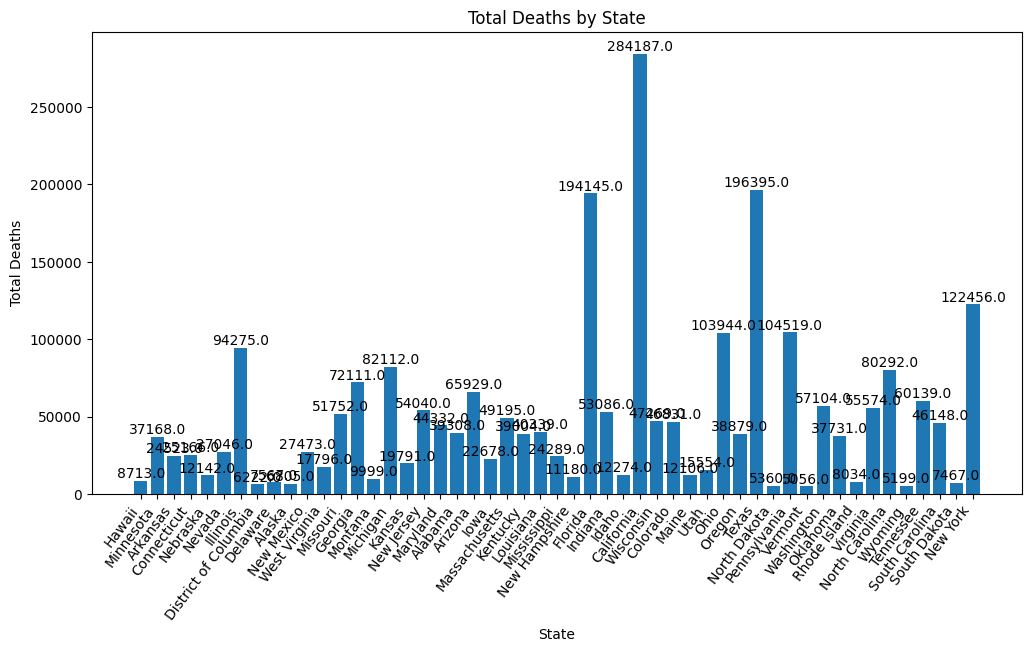

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
pandas_df = total_deaths_by_state.toPandas()

plt.figure(figsize=(12, 6))
bars = plt.bar(pandas_df["LocationDesc"], pandas_df["TotalDeaths"])
plt.xlabel("State")
plt.ylabel("Total Deaths")
plt.title("Total Deaths by State")
plt.xticks(rotation=53, ha="right")

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

plt.show()


2. **Deaths by Cause of Deaths**

In [ ]:
df_filtered2 = df_filtered.filter(col("Cause_of_Death") != "Total for All Causes")
deaths_by_cause = df_filtered2.groupBy("Cause_of_Death").agg(
    sum("Data_Value").alias("TotalDeaths"),
    avg("Data_Value").alias("AverageDeaths"),

)
deaths_by_cause_sorted = deaths_by_cause.orderBy(col("TotalDeaths").desc())
deaths_by_cause_sorted.show()


+--------------------+-----------+------------------+
|      Cause_of_Death|TotalDeaths|     AverageDeaths|
+--------------------+-----------+------------------+
|Alcoholic liver d...|   267996.0|430.17014446227927|
|Poisoning (not al...|   206385.0| 328.1160572337043|
|Motor vehicle tra...|   154365.0|212.03983516483515|
|        Hypertension|   148717.0| 279.0187617260788|
|             Suicide|   131943.0|194.60619469026548|
|Liver cirrhosis, ...|   125238.0|232.35250463821893|
|            Homicide|   103240.0|179.86062717770034|
|Coronary heart di...|    90892.0|214.87470449172577|
|Alcohol dependenc...|    61158.0|130.40085287846483|
|       Cancer, liver|    43378.0|147.54421768707482|
|       Alcohol abuse|    42768.0|101.58669833729216|
| Stroke, hemorrhagic|    37908.0|102.45405405405405|
|  Cancer, colorectal|    33151.0|114.70934256055364|
|Cancer, breast (f...|    28489.0| 61.93260869565217|
|Cancer, oral cavi...|    28051.0| 99.82562277580071|
|   Alcohol poisoning|    25

In [ ]:

top_2_causes = deaths_by_cause_sorted.limit(2)
print("Top 2 causes of death:")
top_2_causes.show()
deaths_by_cause_sorted_asc = deaths_by_cause.orderBy(col("TotalDeaths"))
bottom_2_causes = deaths_by_cause_sorted_asc.limit(2).orderBy(col("TotalDeaths"))
print("Bottom 2 causes of death:")
bottom_2_causes.show()


Top 2 causes of death:
+--------------------+-----------+------------------+
|      Cause_of_Death|TotalDeaths|     AverageDeaths|
+--------------------+-----------+------------------+
|Alcoholic liver d...|   267996.0|430.17014446227927|
|Poisoning (not al...|   206385.0| 328.1160572337043|
+--------------------+-----------+------------------+

Bottom 2 causes of death:
+--------------------+-----------+-----------------+
|      Cause_of_Death|TotalDeaths|    AverageDeaths|
+--------------------+-----------+-----------------+
|Infant death, sma...|        0.0|              0.0|
|  Alcoholic myopathy|       12.0|0.631578947368421|
+--------------------+-----------+-----------------+



If we Observe from the above Most of the deaths occured due to Alocholic liver disease and less deaths occured due to Infant death, small for gestational and Alcoholic myopathy

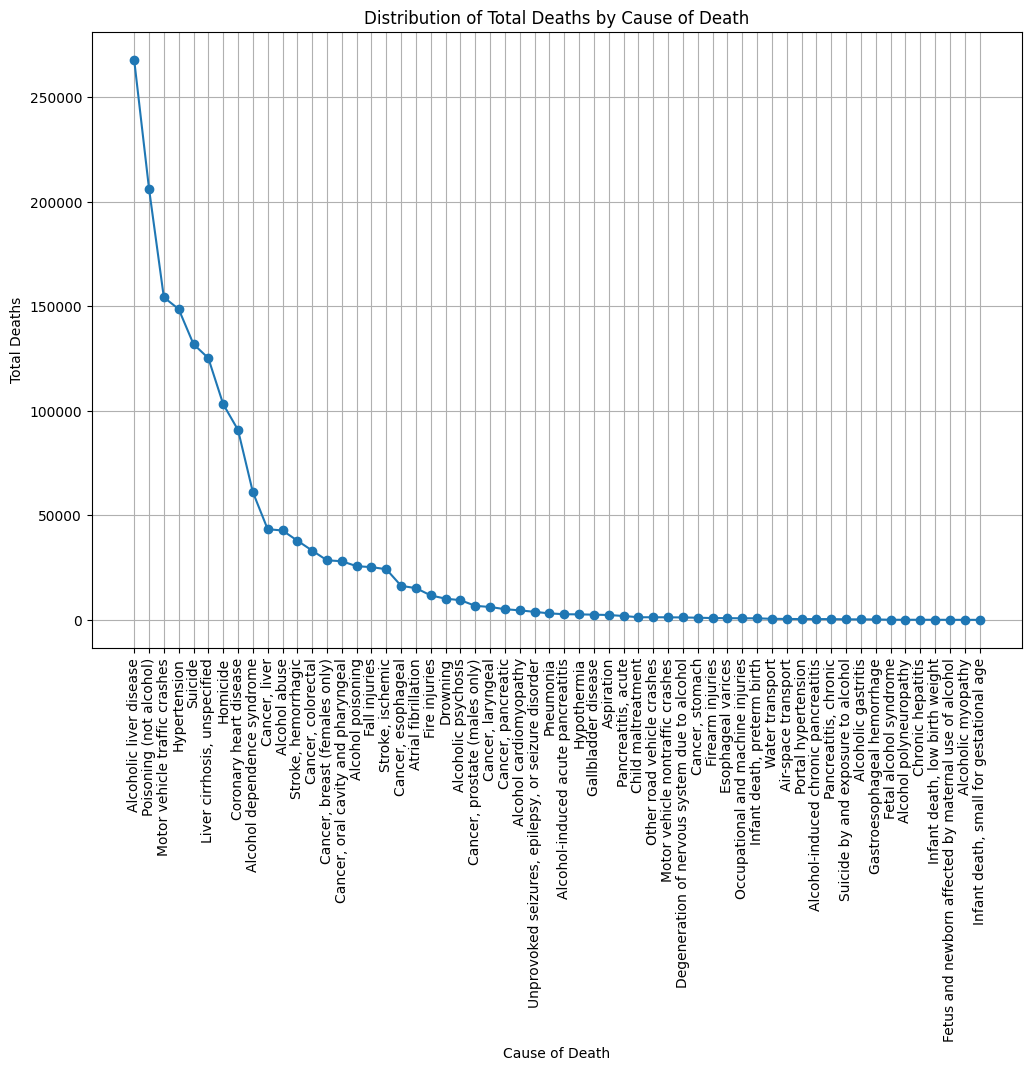

In [ ]:
pandas_df = deaths_by_cause_sorted.toPandas()

# Plot Line graph
plt.figure(figsize=(12, 8))
plt.plot(pandas_df['Cause_of_Death'], pandas_df['TotalDeaths'], marker='o', linestyle='-')
plt.xlabel('Cause of Death')
plt.ylabel('Total Deaths')
plt.title('Distribution of Total Deaths by Cause of Death')
plt.xticks(rotation=90, ha='center')
plt.grid(True)
plt.show()

3. **Deaths by Age Group**

In [ ]:
df_filtered3 = df_filtered.filter(col("AgeGroup") != "Overall")
deaths_by_age_group = df_filtered3.groupBy("AgeGroup").agg(
    sum("Data_Value").alias("TotalDeaths"),
    avg("Data_Value").alias("AverageDeaths")
)
deaths_by_age_group = deaths_by_age_group.orderBy(col("TotalDeaths").desc())
deaths_by_age_group.show()

+--------+-----------+------------------+
|AgeGroup|TotalDeaths|     AverageDeaths|
+--------+-----------+------------------+
|     65+|   597115.0|  300.510820332159|
|   50-64|   543887.0|304.86939461883406|
|   35-49|   300516.0|247.95049504950495|
|   20-34|   224354.0| 313.3435754189944|
|    0-19|    32560.0| 54.90725126475548|
|Under 21|    11996.0|29.046004842615012|
+--------+-----------+------------------+



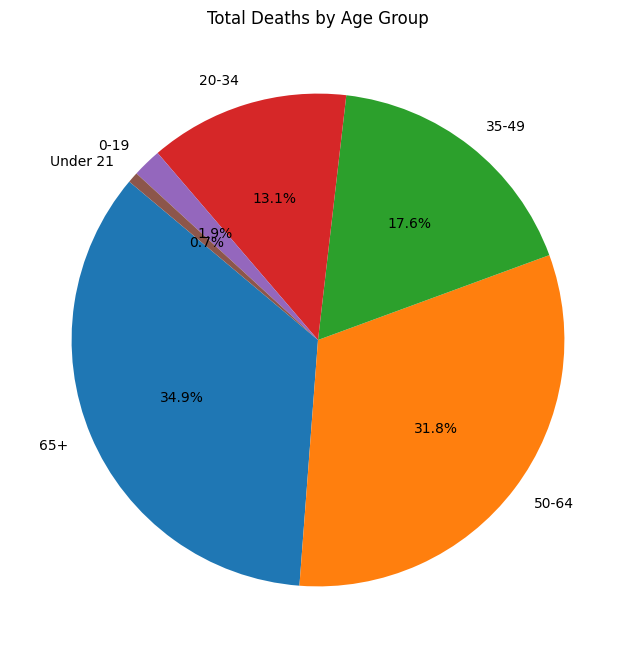

In [ ]:

pandas_df = deaths_by_age_group.toPandas()
plt.figure(figsize=(8, 8))
plt.pie(pandas_df["TotalDeaths"], labels=pandas_df["AgeGroup"], autopct='%1.1f%%', startangle=140)
plt.title("Total Deaths by Age Group")
plt.show()

If we observe the above pie chart most of the Alcohol related deaths occured in the age group above 65

**4. Deaths by Gender**

In [ ]:
df_filtered4 = df_filtered.filter(col("Sex") != "Overall")
deaths_by_gender = df_filtered4.groupBy("Sex").agg(
    sum("Data_Value").alias("TotalDeaths"),
    avg("Data_Value").alias("AverageDeaths"),
)
deaths_by_gender.show()

+------+-----------+------------------+
|   Sex|TotalDeaths|     AverageDeaths|
+------+-----------+------------------+
|Female|   526922.0|253.08453410182517|
|  Male|  1194920.0| 585.7450980392157|
+------+-----------+------------------+



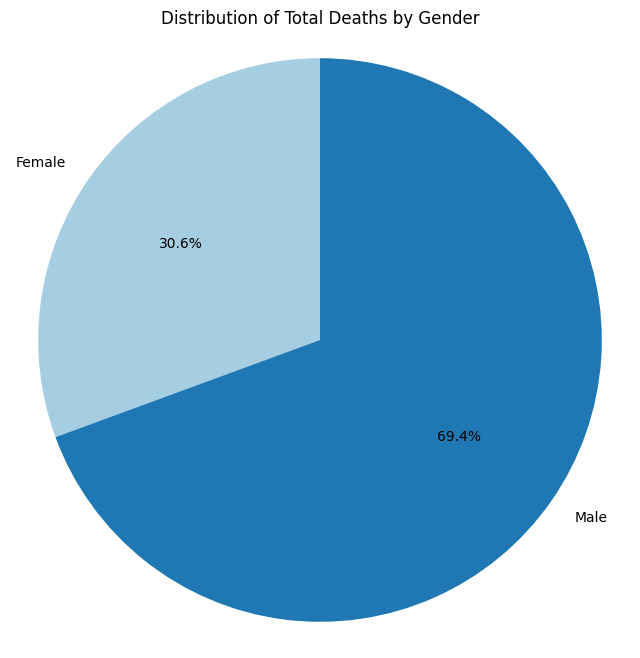

In [ ]:
pandas_df_gender = deaths_by_gender.toPandas()
plt.figure(figsize=(8, 8))
plt.pie(pandas_df_gender['TotalDeaths'], labels=pandas_df_gender['Sex'], autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
plt.title('Distribution of Total Deaths by Gender')
plt.axis('equal')
plt.show()

If we Observe the above Pie chart about 70% of the Males are affected by the Alcohol related diseases

**Remaining Visualizations are done in Tableau**

**Pearson Correlation Coefficient**

In [ ]:
from pyspark.ml.feature import StringIndexer


categorical_column = "AgeGroup"
numerical_column = "Data_Value"


indexer = StringIndexer(inputCol=categorical_column, outputCol="indexed_" + categorical_column)
df_indexed = indexer.fit(df_filtered).transform(df_filtered)

df_categorical_numerical = df_indexed.select("indexed_" + categorical_column, numerical_column)
correlation = df_categorical_numerical.stat.corr("indexed_" + categorical_column, numerical_column)
print("Pearson Correlation Coefficient:")
print(f"Indexed {categorical_column} vs {numerical_column}: {correlation}")


Pearson Correlation Coefficient:
Indexed AgeGroup vs Data_Value: -0.01795030990204142


The Pearson Correlation Coefficient is a measure of the linear relationship between two variables. It ranges from -1 to 1, where:

1 indicates a perfect positive linear relationship,
-1 indicates a perfect negative linear relationship, and
0 indicates no linear relationship.

In our case, a Pearson Correlation Coefficient of approximately -0.018 suggests a very weak negative linear relationship between the "Indexed AgeGroup" and "Data_Value" columns. The value is close to zero, indicating that there is little to no linear correlation between the two variables

**Chi-Square Test**

In [ ]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import ChiSquareTest


spark = SparkSession.builder.appName("ChiSquareTestExample").getOrCreate()
indexer_sex = StringIndexer(inputCol="Sex", outputCol="SexIndex")
indexer_effect = StringIndexer(inputCol="Effect", outputCol="EffectIndex")

df_indexed = indexer_sex.fit(df_filtered).transform(indexer_effect.fit(df_filtered).transform(df_filtered))


assembler = VectorAssembler(inputCols=["SexIndex", "EffectIndex"], outputCol="features")
df_assembled = assembler.transform(df_indexed)

chi_square_test = ChiSquareTest.test(df_assembled, "features", "EffectIndex")
print("Chi-square Test Results:")
chi_square_test.show()

alpha = 0.05
p_value = chi_square_test.collect()[0]["pValues"][0]

print("\nP-value: {}".format(p_value))
print("\nSignificance Test:")
if p_value < alpha:
    print("Reject the null hypothesis. There is a significant association.")
else:
    print("Fail to reject the null hypothesis. There is no significant association.")


spark.stop()

Chi-square Test Results:
+--------------------+----------------+--------------------+
|             pValues|degreesOfFreedom|          statistics|
+--------------------+----------------+--------------------+
|[0.00117991152079...|          [2, 1]|[13.4846316513795...|
+--------------------+----------------+--------------------+


P-value: 0.001179911520798882

Significance Test:
Reject the null hypothesis. There is a significant association.


From the above Chi-Square test we can conclude that there is a significant association between Sex and the Effect of Alcohol on Deaths